The first step is to create the neccesary import schema

In [15]:
from cassandra.cluster import Cluster
from cassandra.cluster import DCAwareRoundRobinPolicy

cluster = Cluster(['dse'],
                  load_balancing_policy=DCAwareRoundRobinPolicy(local_dc='dc1'))  # provide contact points and port
session = cluster.connect()
rows = session.execute(
    "CREATE KEYSPACE IF NOT EXISTS anime WITH replication = {'class':'SimpleStrategy', 'replication_factor':2};")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Legacy execution parameters will be removed in 4.0. Consider using execution profiles.
  """


Import the tables

In [16]:
session.execute("""CREATE TABLE anime.useranimelist (
	username text,
	anime_id int,
	my_watched_episodes int,
	my_start_date text,
	my_finish_date text,
	my_score int,
	my_status int,
	my_rewatching text,
	my_rewatching_ep text,
	my_last_updated text,
	my_tags text,

	PRIMARY KEY (username, anime_id)
) WITH bloom_filter_fp_chance = 0.01
AND comment = ''
AND crc_check_chance = 1.0
AND dclocal_read_repair_chance = 0.1
AND default_time_to_live = 0
AND gc_grace_seconds = 864000
AND max_index_interval = 2048
AND memtable_flush_period_in_ms = 0
AND min_index_interval = 128
AND read_repair_chance = 0.0
AND speculative_retry = '99.0PERCENTILE'
AND caching = {
	'keys' : 'ALL',
	'rows_per_partition' : 'NONE'
}
AND compression = {
	'chunk_length_in_kb' : 16,
	'class' : 'LZ4Compressor',
	'crc_check_chance' : 1.0,
	'enabled' : true
}
AND compaction = {
	'bucket_high' : 1.5,
	'bucket_low' : 0.5,
	'class' : 'SizeTieredCompactionStrategy',
	'enabled' : true,
	'max_threshold' : 32,
	'min_sstable_size' : 50,
	'min_threshold' : 4,
	'tombstone_compaction_interval' : 86400,
	'tombstone_threshold' : 0.2,
	'unchecked_tombstone_compaction' : false
};""")

In [17]:
session.execute("""
CREATE TABLE anime.animelist (
	anime_id int,
	aired text,
	airing text,
	background text,
	broadcast text,
	duration text,
	ending_theme text,
	episodes int,
	favorites bigint,
	genre text,
	image_url text,
	licensor text,
	members bigint,
	opening_theme text,
	popularity bigint,
	premiered text,
	producer text,
	rank bigint,
	rating text,
	related text,
	score decimal,
	scored_by bigint,
	source text,
	status text,
	studio text,
	title text,
	title_english text,
	title_japanese text,
	title_synonyms text,
	type text,
	PRIMARY KEY (anime_id)
) WITH bloom_filter_fp_chance = 0.01
AND comment = ''
AND crc_check_chance = 1.0
AND dclocal_read_repair_chance = 0.1
AND default_time_to_live = 0
AND gc_grace_seconds = 864000
AND max_index_interval = 2048
AND memtable_flush_period_in_ms = 0
AND min_index_interval = 128
AND read_repair_chance = 0.0
AND speculative_retry = '99.0PERCENTILE'
AND caching = {
	'keys' : 'ALL',
	'rows_per_partition' : 'NONE'
}
AND compression = {
	'chunk_length_in_kb' : 16,
	'class' : 'LZ4Compressor',
	'crc_check_chance' : 1.0,
	'enabled' : true
}
AND compaction = {
	'bucket_high' : 1.5,
	'bucket_low' : 0.5,
	'class' : 'SizeTieredCompactionStrategy',
	'enabled' : true,
	'max_threshold' : 32,
	'min_sstable_size' : 50,
	'min_threshold' : 4,
	'tombstone_compaction_interval' : 86400,
	'tombstone_threshold' : 0.2,
	'unchecked_tombstone_compaction' : false
};


""")

Traceback (most recent call last):
  File "cassandra/cluster.py", line 3522, in cassandra.cluster.ControlConnection._reconnect_internal
  File "cassandra/cluster.py", line 3544, in cassandra.cluster.ControlConnection._try_connect
  File "cassandra/cluster.py", line 1620, in cassandra.cluster.Cluster.connection_factory
  File "cassandra/connection.py", line 840, in cassandra.connection.Connection.factory
cassandra.OperationTimedOut: errors=Timed out creating connection (5 seconds), last_host=None
Traceback (most recent call last):
  File "cassandra/cluster.py", line 3522, in cassandra.cluster.ControlConnection._reconnect_internal
  File "cassandra/cluster.py", line 3544, in cassandra.cluster.ControlConnection._try_connect
  File "cassandra/cluster.py", line 1620, in cassandra.cluster.Cluster.connection_factory
  File "cassandra/connection.py", line 840, in cassandra.connection.Connection.factory
cassandra.OperationTimedOut: errors=Timed out creating connection (5 seconds), last_host=Non

Traceback (most recent call last):
  File "cassandra/cluster.py", line 3522, in cassandra.cluster.ControlConnection._reconnect_internal
  File "cassandra/cluster.py", line 3544, in cassandra.cluster.ControlConnection._try_connect
  File "cassandra/cluster.py", line 1620, in cassandra.cluster.Cluster.connection_factory
  File "cassandra/connection.py", line 840, in cassandra.connection.Connection.factory
cassandra.OperationTimedOut: errors=Timed out creating connection (5 seconds), last_host=None
Traceback (most recent call last):
  File "cassandra/cluster.py", line 3522, in cassandra.cluster.ControlConnection._reconnect_internal
  File "cassandra/cluster.py", line 3544, in cassandra.cluster.ControlConnection._try_connect
  File "cassandra/cluster.py", line 1620, in cassandra.cluster.Cluster.connection_factory
  File "cassandra/connection.py", line 840, in cassandra.connection.Connection.factory
cassandra.OperationTimedOut: errors=Timed out creating connection (5 seconds), last_host=Non

Next the data must be imported first (dsbulk tool) using the dataset from https://www.kaggle.com/azathoth42/myanimelist

The following csv's need to be imported
 * UserAnimeList.csv
 * AnimeList.csv

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.functions import avg
from pyspark.sql.functions import sum
from pyspark.sql.functions import desc

spark = SparkSession.builder.appName('demo').master("dse://?").getOrCreate()

spark.catalog.clearCache()

animeDF = spark.read.format("org.apache.spark.sql.cassandra").options(table="animelist", keyspace="anime").load().cache()
animeusersDF = spark.read.format("org.apache.spark.sql.cassandra").options(table="useranimelist", keyspace="anime").load()

stage2 = animeusersDF.groupBy("anime_id").agg(sum("my_score"),avg("my_score"))


In [2]:
result1 = stage2.sort(desc("sum(my_score)")).join(animeDF,stage2.anime_id==animeDF.anime_id).select(
    animeDF.title_english,"sum(my_score)").limit(10).toPandas()


<AxesSubplot:title={'center':'Top 10 highest accumulative Anime score'}, xlabel='title_english'>

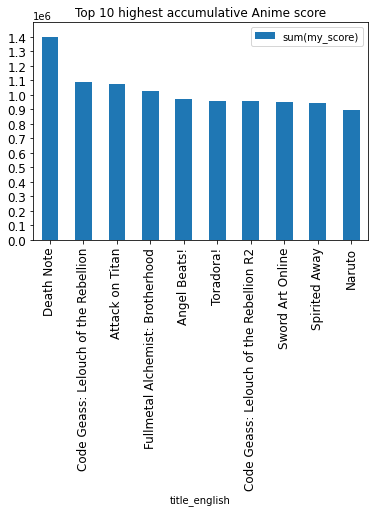

In [3]:
from IPython.display import display
import numpy as np

output1 = result1.plot.bar(x='title_english', y='sum(my_score)', rot='vertical', yticks=np.arange(0, 1500000, 100000),
                     fontsize=12, ylim=(0,1500000), title="Top 10 highest accumulative Anime score")
display(output1)

In [5]:
result2 = stage2.sort(desc("avg(my_score)")).join(animeDF,stage2.anime_id==animeDF.anime_id).select(
    animeDF.title_english,"avg(my_score)").limit(10).toPandas()

<AxesSubplot:title={'center':'Top 10 highest average Anime score'}, xlabel='title_english'>

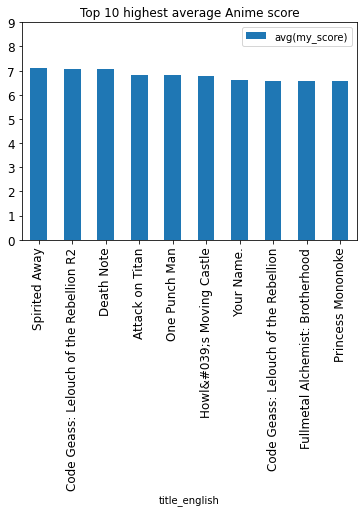

In [40]:
from IPython.display import display
import numpy as np

output2 = result2.plot.bar(x='title_english', y='avg(my_score)', rot='vertical', yticks=np.arange(0, 10, 1),
                     fontsize=12, title="Top 10 highest average Anime score")
display(output2)